In [2]:
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

sys.path.append('../src')

import columnar as col



plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

# Testing Mean Target Encoding vs categorical data embeddings
## Prediction Task
Predict whether an adult's income is higher or lower than $50k, using census information

### Dataset
We are leveraging the Adult dataset, which provides various census features about individuals and aims to predict whether an individual is earning over $50k or not.
[https://archive.ics.uci.edu/ml/datasets/Adult](https://archive.ics.uci.edu/ml/datasets/Adult)

### Definitions
* **Mean Target Encoding** is a technique to transform categorical data into numerical by replacing the categorical value by the mean target value for all observations belonging to that category.
* **Categorical data embeddings** is a potentially more expressive generalization of MTE which represents each categorical value as an embedding. embeddings sizes can be defined based on the cardinality of each feature. An embedding of size 1 should replicate closely the principle of MTE (even though values are learnt more indireclty), but weights are learnt instead of explicitly defined.

## Load Data

In [3]:
COL_NAMES = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital-status', 'occupation',
             'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('../data/raw/adult.data', header=None)
df.columns = COL_NAMES
df['target'] = (df.income.str.strip() == '>50K')
df.sample(5)

,age,workclass,fnlwgt,education,education_num,marital-status,occupation,relationship,race,sex,capital_gain,capital_loss,hours-per-week,native-country,income,target
1533,49,Private,245305,10th,6,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,42,United-States,>50K,True
19143,53,Local-gov,216691,Doctorate,16,Divorced,Prof-specialty,Not-in-family,White,Female,10520,0,40,United-States,>50K,True
14048,47,Private,169549,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K,True
29624,25,Local-gov,45474,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,60,United-States,<=50K,False
20761,40,Private,213821,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,>50K,True


## Define Metrics for Success

In [4]:
# define scoring metrics of interest
scorer = col.Scorer(
    acc=metrics.accuracy_score,
    f1=metrics.f1_score,
    auc=metrics.roc_auc_score,
)

# create a reporting object
reporter = col.Report(scorer=scorer)

# define which columns should be shown when reporting experiments results so far
reporter.set_columns_to_show(['encoder'] + list(scorer.scoring_fcts.keys()))

print(reporter)

Report(
        scorer: Scorer(scoring_fcts=[acc,f1,auc]), 
        to_show: [encoder,acc,f1,auc]
        )


## Define Cross Validation Strategy

In [5]:
# cross validation strategy
kf = KFold(n_splits=5)

## Feature Selection and Processing
* encode categorical variables using mean target encoding
* pass through all numerical variables

In [6]:
numericals = df.select_dtypes(np.number).columns.tolist()
categoricals = df.select_dtypes('object').columns.tolist()
categoricals.remove('income')

# select features to use in the model
feature_selection = col.FeatureSelection(
    categoricals=categoricals,
    numericals=numericals,
    target= 'target')

print(feature_selection)

FeatureSelection(categoricals=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], numericals=['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours-per-week'], target='target')


## Model Selection and Fitting

In [7]:
# define fitting function
mte_encoder = col.MeanTargetEncoder(feature_selection)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=mte_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score.mean(), show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.85194,0.625869,0.73669


## Compare to Baseline
### Baseline 1: Assign all predictions to majority class

In [8]:
# baseline: assign all predictions to majority class
maj_results = pd.Series(reporter.score(df.target, np.zeros(len(df))))
maj_config = dict(features=str(feature_selection),
                         encoder='MajorityClass',
                         model='Nonę')

reporter.add_to_report(maj_config, maj_results, show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.85194,0.625869,0.73669
1,MajorityClass,0.75919,0.000000,0.50000


## Baseline 2: one hot encode all categories

In [9]:
# define fitting function
ohe_encoder = OneHotEncoder(handle_unknown='ignore')

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=ohe_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score.mean(), show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851940,0.625869,0.736690
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.836952,0.552451,0.693973


## Baseline 3: OrdinalEncoder

In [10]:
# define fitting function
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=ord_encoder)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

reporter.add_to_report(pipe.config, cv_score.mean(), show=True)

,encoder,acc,f1,auc
0,"MeanTargetEncoder(target=target, alpha=5)",0.851940,0.625869,0.736690
1,MajorityClass,0.759190,0.000000,0.500000
2,OneHotEncoder(handle_unknown='ignore'),0.836952,0.552451,0.693973
3,OrdinalEncoder(handle_unknown='use_encoded_val...,0.849882,0.614598,0.729452


## Inspect MTE output

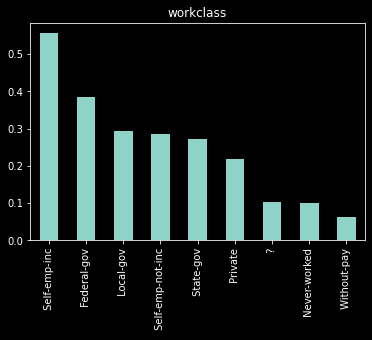

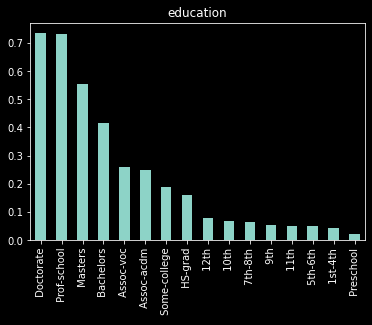

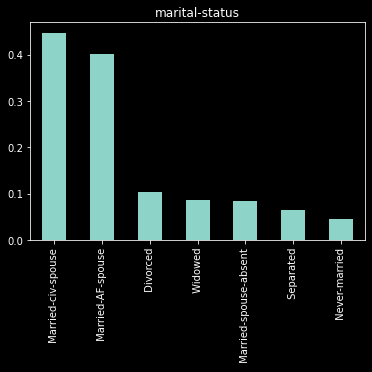

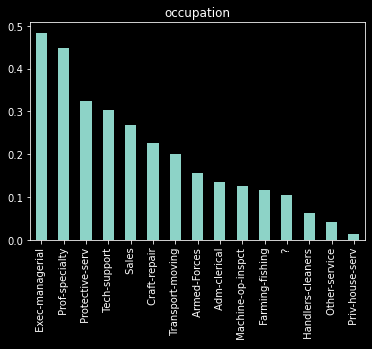

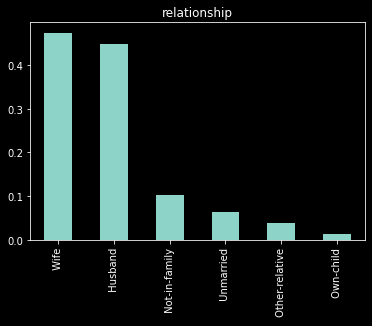

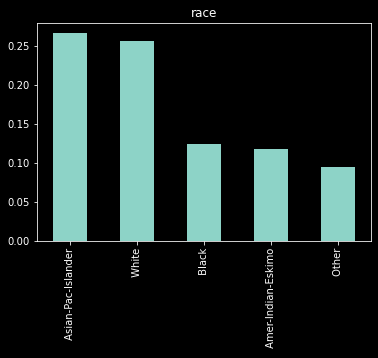

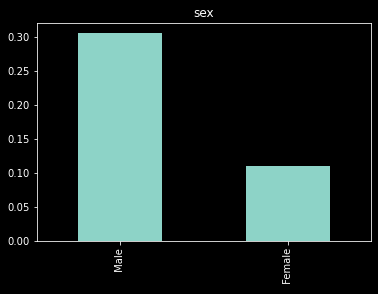

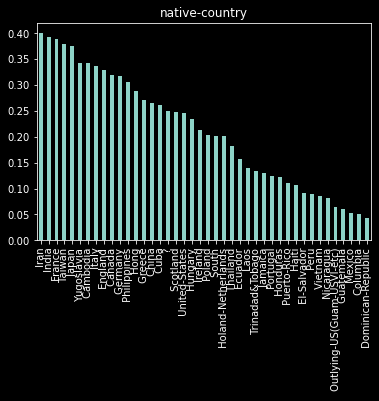

In [11]:
# define fitting function
mte_encoder = col.MeanTargetEncoder(feature_selection)

pipe = col.CategoricalPipeline(features=feature_selection,
                               model=RandomForestClassifier(n_estimators=100, max_depth=5),
                               encoder=mte_encoder)

# train model on entire dataset (no CV)
pipe.fit(df)



# get Mean Target Encoder learned weights for each categorical variable:
mapper = pipe.pipe[0].named_transformers_['categories'].mapper
for k, v in mapper.items():
    pd.Series(v).sort_values(ascending=False).plot.bar()
    plt.title(k)
    plt.show()


## Plot Feature Importance

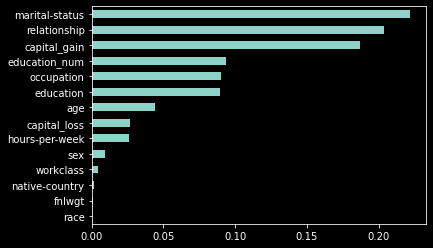

<Figure size 432x288 with 0 Axes>

In [12]:
def plot_feature_importance(pipe: col.CategoricalPipeline, *args, **kwargs):
    fi = (pd.Series(pipe.model.feature_importances_, 
                   index=pipe.features.categoricals + pipe.features.numericals)
          .sort_values())
    fi.plot.barh(*args, **kwargs)
    plt.show()


plot_feature_importance(pipe)
plt.savefig('../figures/feature_importance.png', facecolor='white');

In [25]:
# number of unique values for each categorical column
{col: df[col].nunique() for col in feature_selection.categoricals}

{'workclass': 9,
 'education': 16,
 'marital-status': 7,
 'occupation': 15,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 42}

# Compare value of MTE for linear models vs non-linear (RandomForest)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.base import clone

reporter = col.Report(scorer=scorer)
reporter.set_columns_to_show(['model', 'encoder'] + list(scorer.scoring_fcts.keys()))

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5),
    LogisticRegression(max_iter=500),
    KNeighborsClassifier(n_neighbors=5)
]

encoders = [
    col.MeanTargetEncoder(feature_selection),
    OneHotEncoder(handle_unknown='ignore'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
]

for model in models:
    for encoder in encoders:
        pipe = col.CategoricalPipeline(features=feature_selection,
                                       model=clone(model),
                                       scaler=MaxAbsScaler(),
                                       encoder=clone(encoder))

        cv_score = col.cv_score(pipeline=pipe,
                                data=df, 
                                kf=kf,
                                scorer=reporter.scorer)
        
        reporter.add_to_report(pipe.config, cv_score.mean(), show=False)
        
reporter.show()

,model,encoder,acc,f1,auc
0,RandomForestClassifier(max_depth=5),"MeanTargetEncoder(target=target, alpha=5)",0.852738,0.630378,0.739635
1,RandomForestClassifier(max_depth=5),OneHotEncoder(handle_unknown='ignore'),0.838549,0.553552,0.694245
2,RandomForestClassifier(max_depth=5),OrdinalEncoder(handle_unknown='use_encoded_val...,0.849974,0.614211,0.729156
3,LogisticRegression(max_iter=500),"MeanTargetEncoder(target=target, alpha=5)",0.845429,0.639919,0.751560
4,LogisticRegression(max_iter=500),OneHotEncoder(handle_unknown='ignore'),0.850220,0.656654,0.763041
5,LogisticRegression(max_iter=500),OrdinalEncoder(handle_unknown='use_encoded_val...,0.822978,0.545481,0.692627
6,KNeighborsClassifier(),"MeanTargetEncoder(target=target, alpha=5)",0.828845,0.620366,0.744162
7,KNeighborsClassifier(),OneHotEncoder(handle_unknown='ignore'),0.825958,0.616923,0.742695
8,KNeighborsClassifier(),OrdinalEncoder(handle_unknown='use_encoded_val...,0.824484,0.611581,0.738963


### plot the 3 metrics for each model / encoder pair

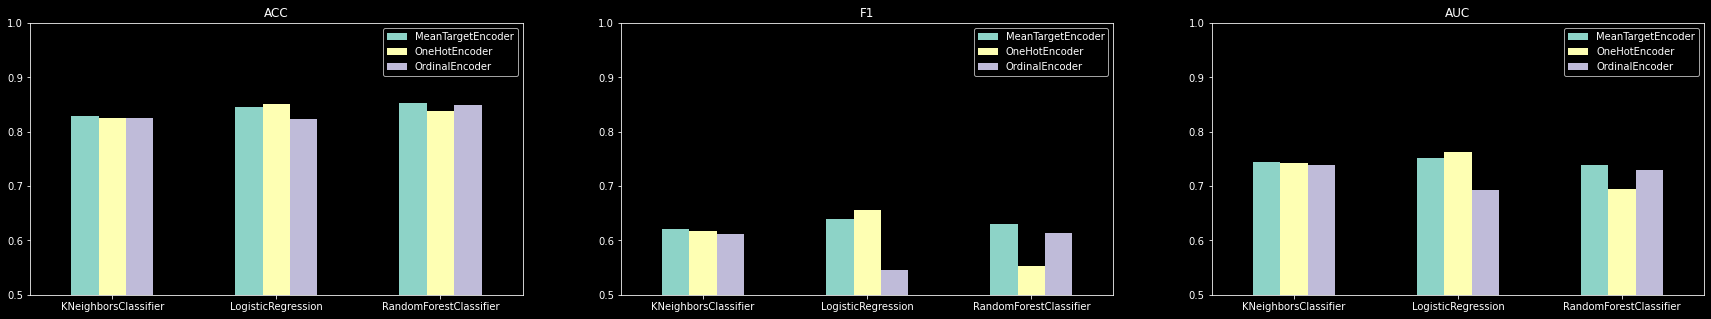

In [24]:
col.plot_model_encoder_pairs(reporter, figpath=f'../figures/model_encoder_comparison.png')